In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *
import itertools
#import scienceplots
#plt.style.use(['science','no-latex','grid'])

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(batch_size,-1,self.output_size).mean(axis=1)
        
class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda', num_layers:tuple=(1,1)) -> None:
        
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        self.num_layers = num_layers                    # num_layers of LSTMs
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 3                  # num_predicate is same as num_node
        self.num_formula = 3                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.6               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0]
        self.action_predicate_set = [1, 2]
        self.head_predicate_set = [0, 1, 2]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        #self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device,num_layers=self.num_layers[0])
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=len(self.mental_predicate_set),hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device,num_layers=self.num_layers[1])
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)



        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()

    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 1 and 2 and before(1, 0) and before(2,0) \to \neg 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        '''
        Action (3-6)
        '''
        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 0 and before(0,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 0 and equal(0,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.EQUAL]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0)) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)
        #print(head_predicate_idx, intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
                #print(intensity_integral)
                #print(head_predicate_idx,data_sample,intensity_integral)
                #print(log_likelihood)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        #NOTE: shape (batch_size:len(action_history), num_predicate:len(self.action_predicate_set), seq_length:max_action_transition_time_length)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        #TODO: store the action history in a tensor
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch:list, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            sample_ID_batch: the collection of batch indices
            action_history: action information
            temperature: 
        '''

        #NOTE: we add a small time shift 1e-4 so that we can include the end time point in 'time_intervals'
        time_intervals = np.arange(0,self.time_horizon+1e-4,step=self.partition_size)
        #print(time_intervals) #NOTE: checkpoint

        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history) #NOTE: checkpoint
        #TODO: initilize, store mental history, this will be fed into the LSTM
        mental_history = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)

        ELBO = (torch.zeros(size=(1,self.batch_size))).to(device)    #NOTE: initialize ELBO
        
        #TODO: encode the mental history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:]) #h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for i in range(len(time_intervals)-1):
            #TODO: encode the mental history before the i-th time interval (LSTMs) -> categorical distribution -> prob
            # prob (batch_size, 1, num_mental_predicate+1)
            prob:torch.tensor = self.LSTM_History.forward(x=mental_history,action_embedding=h_a)
            #print(prob)

            #TODO: ELBO = ELBO + self.entropy_variational posterior
            ELBO += self.entropy_variational_posterior(prob,device=device)
            #print(ELBO)

            # logits (batch_size, 1, num_mental_predicate+1)
            logits:torch.tensor = torch.log(prob)
            #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
            post_samples:torch.tensor = self.sample_variational_posterior(size=1,logits=logits,temperature=temperature,hard=True)
            #print(post_samples)

            #TODO: after sampling the mental transition time, update the history information
            event_time = (time_intervals[i] + time_intervals[i+1])/2
            event_time += np.random.normal(loc=0,scale=event_time/8)
            _, indices = post_samples.max(dim=2)
            indices = indices.detach().cpu().numpy().squeeze()
            #print(indices)
            new_mental_information = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)
            #print(new_mental_information)

            for batch_idx, idx in enumerate(indices):
                if idx == 0: continue   #NOTE: no mental
                #TODO: We have mental; update the mental history
                new_mental_information[batch_idx,0,idx-1] = event_time
                #TODO: update the complete history, which is a dict
                sample_id = sample_ID_batch[batch_idx]
                complete_history[sample_id][idx-1]['time'].append(event_time)
                #print(idx-1)   #NOTE: checkpoint
                if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                else: complete_history[sample_id][idx-1]['state'].append(0)
            #print(new_mental_information) #NOTE:checkpoint
            #TODO: update mental_history
            #mental_history = torch.concat([mental_history,new_mental_information],dim=1)
        #print(complete_history)

        ELBO = torch.sum(ELBO)
        #print(ELBO)

        for idx, batch_idx in enumerate(sample_ID_batch):
            #print(self.log_likelihood(dataset=complete_history,sample_ID_batch=[batch_idx],T_max=self.time_horizon).to(device))
            ELBO += self.log_likelihood(dataset=complete_history,sample_ID_batch=[batch_idx],T_max=self.time_horizon).squeeze().to(device)
        #print(ELBO)
        #TODO: return ELBO
        return ELBO/len(sample_ID_batch)

    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, prob:torch.tensor, device='cuda')->float:
        #TODO: calculate the entropy of the variational posterior
        #TODO: the variational posterior is a categorical distribution
        '''
        Parameters:
            prob (batch_size, num_mental_states+1): probabilities for each category
        '''
        result = -torch.log(prob) * prob
        result = torch.sum(result,dim=1)
        #print(result)
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        #optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        variational_parameters_store = []
        model_parameters_store = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.Adam(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1], eps=1e-8)
        for iter in tqdm(range(num_iter)):
            tmp = 0
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta) #NOTE:-ELBO, want to see it decreases
                tmp += loss.detach().cpu().item()
            losses.append(tmp/num_batch)
            variational_parameters_store.append((list(self.LSTM_History.parameters())[0][0].clone().detach().cpu().numpy()))
            model_parameters_store.append([item.clone().detach().cpu().numpy() for item in model_parameters])
            if iter % 10 == 0:
                print('model parameter >> {}'.format(model_parameters))
                #print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
            print('iter >> {}; loss >> {}'.format(iter+1, tmp/num_batch))
        return losses, variational_parameters_store, model_parameters_store

    def plot_loss(self,losses:list):
        #TODO: plot the losses
        #plt.style.use(['science','grid','no-latex'])
        plt.figure(figsize=(9,3),dpi=150)
        X = np.arange(1,len(losses)+1,1)
        plt.plot(X,losses,label='$-\mathcal{L}(\\theta,\psi,\mathcal{H}_a(T))$')
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('iter')
        plt.ylabel('negative ELBO')
        plt.show()

In [151]:
np.random.seed(1)
torch.manual_seed(1)

def generate_incomplete_data(num_sample:int=10, time_horizon:float=0.5):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [1,2]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=24,time_horizon=4)
model = Logic_Model_Incomplete_Data(time_horizon=4,action_history=action_history,hidden_size=(15,10),output_size=(10,2),batch_size=12,num_layers=(1,1))
losses, variational_parameter_store, model_parameters_store  = model.train_model(num_iter=500,lr=(1e-3,0.01))

[INFO] data has been generated!!!


  0%|          | 1/500 [00:02<18:55,  2.28s/it]

model parameter >> [tensor([-0.2980], dtype=torch.float64, requires_grad=True), tensor([0.0080], dtype=torch.float64, requires_grad=True), tensor([-0.3020], dtype=torch.float64, requires_grad=True), tensor([0.0180], dtype=torch.float64, requires_grad=True), tensor([-0.2018], dtype=torch.float64, requires_grad=True), tensor([0.0982], dtype=torch.float64, requires_grad=True)]
iter >> 1; loss >> 50135.8134765625


  0%|          | 2/500 [00:04<19:09,  2.31s/it]

iter >> 2; loss >> 13935.21630859375


  1%|          | 3/500 [00:07<20:33,  2.48s/it]

iter >> 3; loss >> 44949.02099609375


  1%|          | 4/500 [00:09<20:11,  2.44s/it]

iter >> 4; loss >> 82933.71875


  1%|          | 5/500 [00:12<19:57,  2.42s/it]

iter >> 5; loss >> 73100.2138671875


  1%|          | 6/500 [00:14<19:52,  2.41s/it]

iter >> 6; loss >> 62742.09130859375


  1%|▏         | 7/500 [00:16<19:44,  2.40s/it]

iter >> 7; loss >> 34035.9130859375


  2%|▏         | 8/500 [00:19<19:38,  2.40s/it]

iter >> 8; loss >> 47405.32421875


  2%|▏         | 9/500 [00:21<19:38,  2.40s/it]

iter >> 9; loss >> 109331.07421875


  2%|▏         | 10/500 [00:23<19:31,  2.39s/it]

iter >> 10; loss >> 65088.18359375


  2%|▏         | 11/500 [00:26<19:34,  2.40s/it]

model parameter >> [tensor([-0.2779], dtype=torch.float64, requires_grad=True), tensor([-0.0120], dtype=torch.float64, requires_grad=True), tensor([-0.3187], dtype=torch.float64, requires_grad=True), tensor([0.0019], dtype=torch.float64, requires_grad=True), tensor([-0.2185], dtype=torch.float64, requires_grad=True), tensor([0.0819], dtype=torch.float64, requires_grad=True)]
iter >> 11; loss >> 21329.7568359375


  2%|▏         | 12/500 [00:28<19:29,  2.40s/it]

iter >> 12; loss >> 20472.220703125


  3%|▎         | 13/500 [00:31<19:50,  2.44s/it]

iter >> 13; loss >> 11399.60205078125


  3%|▎         | 14/500 [00:33<19:41,  2.43s/it]

iter >> 14; loss >> 38264.17041015625


  3%|▎         | 15/500 [00:36<19:35,  2.42s/it]

iter >> 15; loss >> 8332.214599609375


  3%|▎         | 16/500 [00:38<19:25,  2.41s/it]

iter >> 16; loss >> 10293.01220703125


  3%|▎         | 17/500 [00:40<19:24,  2.41s/it]

iter >> 17; loss >> 43422.248046875


  4%|▎         | 18/500 [00:43<19:20,  2.41s/it]

iter >> 18; loss >> 10874.701171875


  4%|▍         | 19/500 [00:45<19:19,  2.41s/it]

iter >> 19; loss >> 30452.6123046875


  4%|▍         | 20/500 [00:48<19:16,  2.41s/it]

iter >> 20; loss >> 17978.275390625


  4%|▍         | 21/500 [00:50<19:10,  2.40s/it]

model parameter >> [tensor([-0.2579], dtype=torch.float64, requires_grad=True), tensor([-0.0318], dtype=torch.float64, requires_grad=True), tensor([-0.3339], dtype=torch.float64, requires_grad=True), tensor([-0.0127], dtype=torch.float64, requires_grad=True), tensor([-0.2302], dtype=torch.float64, requires_grad=True), tensor([0.0710], dtype=torch.float64, requires_grad=True)]
iter >> 21; loss >> 57809.90185546875


  4%|▍         | 22/500 [00:52<19:04,  2.40s/it]

iter >> 22; loss >> 39184.828125


  5%|▍         | 23/500 [00:55<19:05,  2.40s/it]

iter >> 23; loss >> 30501.85498046875


  5%|▍         | 24/500 [00:57<18:58,  2.39s/it]

iter >> 24; loss >> 11409.05908203125


  5%|▌         | 25/500 [01:00<19:13,  2.43s/it]

iter >> 25; loss >> 36981.98828125


  5%|▌         | 26/500 [01:02<19:11,  2.43s/it]

iter >> 26; loss >> 74835.1640625


  5%|▌         | 27/500 [01:05<19:01,  2.41s/it]

iter >> 27; loss >> 61691.0390625


  6%|▌         | 28/500 [01:07<18:50,  2.39s/it]

iter >> 28; loss >> 8798.98876953125


  6%|▌         | 29/500 [01:09<18:50,  2.40s/it]

iter >> 29; loss >> 27932.416015625


  6%|▌         | 30/500 [01:12<18:44,  2.39s/it]

iter >> 30; loss >> 18504.474609375


  6%|▌         | 31/500 [01:14<18:37,  2.38s/it]

model parameter >> [tensor([-0.2379], dtype=torch.float64, requires_grad=True), tensor([-0.0514], dtype=torch.float64, requires_grad=True), tensor([-0.3501], dtype=torch.float64, requires_grad=True), tensor([-0.0284], dtype=torch.float64, requires_grad=True), tensor([-0.2432], dtype=torch.float64, requires_grad=True), tensor([0.0588], dtype=torch.float64, requires_grad=True)]
iter >> 31; loss >> 7596.853759765625


  6%|▋         | 32/500 [01:16<18:38,  2.39s/it]

iter >> 32; loss >> 37526.576171875


  7%|▋         | 33/500 [01:19<18:43,  2.41s/it]

iter >> 33; loss >> 16417.59814453125


  7%|▋         | 34/500 [01:21<18:35,  2.39s/it]

iter >> 34; loss >> 55385.71875


  7%|▋         | 35/500 [01:24<18:33,  2.39s/it]

iter >> 35; loss >> 9000.711181640625


  7%|▋         | 36/500 [01:26<18:26,  2.38s/it]

iter >> 36; loss >> 26658.25341796875


  7%|▋         | 37/500 [01:29<18:46,  2.43s/it]

iter >> 37; loss >> 6033.5418701171875


  8%|▊         | 38/500 [01:31<18:36,  2.42s/it]

iter >> 38; loss >> 11231.521240234375


  8%|▊         | 39/500 [01:33<18:27,  2.40s/it]

iter >> 39; loss >> 19382.397705078125


  8%|▊         | 40/500 [01:36<18:28,  2.41s/it]

iter >> 40; loss >> 10997.680419921875


  8%|▊         | 41/500 [01:38<18:21,  2.40s/it]

model parameter >> [tensor([-0.2181], dtype=torch.float64, requires_grad=True), tensor([-0.0705], dtype=torch.float64, requires_grad=True), tensor([-0.3642], dtype=torch.float64, requires_grad=True), tensor([-0.0415], dtype=torch.float64, requires_grad=True), tensor([-0.2536], dtype=torch.float64, requires_grad=True), tensor([0.0491], dtype=torch.float64, requires_grad=True)]
iter >> 41; loss >> 26952.95556640625


  8%|▊         | 42/500 [01:41<18:16,  2.39s/it]

iter >> 42; loss >> 12103.70654296875


  9%|▊         | 43/500 [01:43<18:11,  2.39s/it]

iter >> 43; loss >> 29434.705078125


  9%|▉         | 44/500 [01:45<18:07,  2.39s/it]

iter >> 44; loss >> 16928.412475585938


  9%|▉         | 45/500 [01:48<18:02,  2.38s/it]

iter >> 45; loss >> 6596.5458984375


  9%|▉         | 46/500 [01:50<18:06,  2.39s/it]

iter >> 46; loss >> 14547.28759765625


  9%|▉         | 47/500 [01:53<18:21,  2.43s/it]

iter >> 47; loss >> 16176.4951171875


 10%|▉         | 48/500 [01:55<18:09,  2.41s/it]

iter >> 48; loss >> 20695.1162109375


 10%|▉         | 49/500 [01:57<18:05,  2.41s/it]

iter >> 49; loss >> 8846.988525390625


 10%|█         | 50/500 [02:00<17:55,  2.39s/it]

iter >> 50; loss >> 57190.58972167969


 10%|█         | 51/500 [02:02<17:48,  2.38s/it]

model parameter >> [tensor([-0.1983], dtype=torch.float64, requires_grad=True), tensor([-0.0899], dtype=torch.float64, requires_grad=True), tensor([-0.3778], dtype=torch.float64, requires_grad=True), tensor([-0.0539], dtype=torch.float64, requires_grad=True), tensor([-0.2620], dtype=torch.float64, requires_grad=True), tensor([0.0415], dtype=torch.float64, requires_grad=True)]
iter >> 51; loss >> 6363.9443359375


 10%|█         | 52/500 [02:04<17:44,  2.38s/it]

iter >> 52; loss >> 13285.99755859375


 11%|█         | 53/500 [02:07<17:46,  2.38s/it]

iter >> 53; loss >> 75566.73828125


 11%|█         | 54/500 [02:09<17:40,  2.38s/it]

iter >> 54; loss >> 20943.4384765625


 11%|█         | 55/500 [02:12<17:42,  2.39s/it]

iter >> 55; loss >> 14967.75732421875


 11%|█         | 56/500 [02:14<17:42,  2.39s/it]

iter >> 56; loss >> 174334.578125


 11%|█▏        | 57/500 [02:17<17:56,  2.43s/it]

iter >> 57; loss >> 25002.2275390625


 12%|█▏        | 58/500 [02:19<17:53,  2.43s/it]

iter >> 58; loss >> 7363.91845703125


 12%|█▏        | 59/500 [02:21<17:43,  2.41s/it]

iter >> 59; loss >> 5715.523193359375


 12%|█▏        | 60/500 [02:24<17:38,  2.41s/it]

iter >> 60; loss >> 11842.037109375


 12%|█▏        | 61/500 [02:26<17:33,  2.40s/it]

model parameter >> [tensor([-0.1784], dtype=torch.float64, requires_grad=True), tensor([-0.1094], dtype=torch.float64, requires_grad=True), tensor([-0.3915], dtype=torch.float64, requires_grad=True), tensor([-0.0667], dtype=torch.float64, requires_grad=True), tensor([-0.2760], dtype=torch.float64, requires_grad=True), tensor([0.0279], dtype=torch.float64, requires_grad=True)]
iter >> 61; loss >> 25074.1513671875


 12%|█▏        | 62/500 [02:28<17:30,  2.40s/it]

iter >> 62; loss >> 14946.99658203125


 13%|█▎        | 63/500 [02:31<17:31,  2.41s/it]

iter >> 63; loss >> 29642.7880859375


 13%|█▎        | 64/500 [02:33<17:28,  2.40s/it]

iter >> 64; loss >> 10299.60888671875


 13%|█▎        | 65/500 [02:36<17:24,  2.40s/it]

iter >> 65; loss >> 12596.2880859375


 13%|█▎        | 66/500 [02:38<17:20,  2.40s/it]

iter >> 66; loss >> 25628.376953125


 13%|█▎        | 67/500 [02:40<17:15,  2.39s/it]

iter >> 67; loss >> 5017.7626953125


 14%|█▎        | 68/500 [02:43<17:09,  2.38s/it]

iter >> 68; loss >> 10220.034912109375


 14%|█▍        | 69/500 [02:45<17:24,  2.42s/it]

iter >> 69; loss >> 13602.2392578125


 14%|█▍        | 70/500 [02:48<17:18,  2.42s/it]

iter >> 70; loss >> 4186.52880859375


 14%|█▍        | 71/500 [02:50<17:08,  2.40s/it]

model parameter >> [tensor([-0.1584], dtype=torch.float64, requires_grad=True), tensor([-0.1281], dtype=torch.float64, requires_grad=True), tensor([-0.4046], dtype=torch.float64, requires_grad=True), tensor([-0.0789], dtype=torch.float64, requires_grad=True), tensor([-0.2855], dtype=torch.float64, requires_grad=True), tensor([0.0192], dtype=torch.float64, requires_grad=True)]
iter >> 71; loss >> 119804.38842773438


 14%|█▍        | 72/500 [02:52<17:03,  2.39s/it]

iter >> 72; loss >> 20584.14453125


 15%|█▍        | 73/500 [02:55<17:00,  2.39s/it]

iter >> 73; loss >> 26530.5224609375


 15%|█▍        | 74/500 [02:57<16:54,  2.38s/it]

iter >> 74; loss >> 4383.83984375


 15%|█▌        | 75/500 [03:00<16:50,  2.38s/it]

iter >> 75; loss >> 14284.3408203125


 15%|█▌        | 76/500 [03:02<16:50,  2.38s/it]

iter >> 76; loss >> 10809.92529296875


 15%|█▌        | 77/500 [03:04<16:47,  2.38s/it]

iter >> 77; loss >> 15970.86572265625


 16%|█▌        | 78/500 [03:07<16:45,  2.38s/it]

iter >> 78; loss >> 19060.0830078125


 16%|█▌        | 79/500 [03:09<16:43,  2.38s/it]

iter >> 79; loss >> 8867.54736328125


 16%|█▌        | 80/500 [03:12<16:41,  2.39s/it]

iter >> 80; loss >> 13797.3017578125


 16%|█▌        | 81/500 [03:14<16:53,  2.42s/it]

model parameter >> [tensor([-0.1390], dtype=torch.float64, requires_grad=True), tensor([-0.1462], dtype=torch.float64, requires_grad=True), tensor([-0.4140], dtype=torch.float64, requires_grad=True), tensor([-0.0872], dtype=torch.float64, requires_grad=True), tensor([-0.2947], dtype=torch.float64, requires_grad=True), tensor([0.0107], dtype=torch.float64, requires_grad=True)]
iter >> 81; loss >> 13112.9091796875


 16%|█▋        | 82/500 [03:16<16:49,  2.41s/it]

iter >> 82; loss >> 12942.416748046875


 17%|█▋        | 83/500 [03:19<16:48,  2.42s/it]

iter >> 83; loss >> 21633.05517578125


 17%|█▋        | 84/500 [03:21<16:41,  2.41s/it]

iter >> 84; loss >> 14452.287353515625


 17%|█▋        | 85/500 [03:24<16:34,  2.40s/it]

iter >> 85; loss >> 4261.0369873046875


 17%|█▋        | 86/500 [03:26<16:28,  2.39s/it]

iter >> 86; loss >> 28447.5595703125


 17%|█▋        | 87/500 [03:28<16:23,  2.38s/it]

iter >> 87; loss >> 4018.7032470703125


 18%|█▊        | 88/500 [03:31<16:19,  2.38s/it]

iter >> 88; loss >> 7555.029296875


 18%|█▊        | 89/500 [03:33<16:16,  2.37s/it]

iter >> 89; loss >> 7064.169189453125


 18%|█▊        | 90/500 [03:35<16:12,  2.37s/it]

iter >> 90; loss >> 12987.73095703125


 18%|█▊        | 91/500 [03:38<16:29,  2.42s/it]

model parameter >> [tensor([-0.1194], dtype=torch.float64, requires_grad=True), tensor([-0.1644], dtype=torch.float64, requires_grad=True), tensor([-0.4241], dtype=torch.float64, requires_grad=True), tensor([-0.0959], dtype=torch.float64, requires_grad=True), tensor([-0.3010], dtype=torch.float64, requires_grad=True), tensor([0.0053], dtype=torch.float64, requires_grad=True)]
iter >> 91; loss >> 13547.24365234375


 18%|█▊        | 92/500 [03:40<16:23,  2.41s/it]

iter >> 92; loss >> 8648.712768554688


 19%|█▊        | 93/500 [03:43<16:15,  2.40s/it]

iter >> 93; loss >> 10513.87060546875


 19%|█▉        | 94/500 [03:45<16:08,  2.38s/it]

iter >> 94; loss >> 14694.69482421875


 19%|█▉        | 95/500 [03:47<16:03,  2.38s/it]

iter >> 95; loss >> 20807.7734375


 19%|█▉        | 96/500 [03:50<15:58,  2.37s/it]

iter >> 96; loss >> 12562.96142578125


 19%|█▉        | 97/500 [03:52<15:58,  2.38s/it]

iter >> 97; loss >> 10120.388671875


 20%|█▉        | 98/500 [03:55<15:59,  2.39s/it]

iter >> 98; loss >> 14005.107055664062


 20%|█▉        | 99/500 [03:57<15:57,  2.39s/it]

iter >> 99; loss >> 34793.40173339844


 20%|██        | 100/500 [03:59<15:56,  2.39s/it]

iter >> 100; loss >> 5604.960693359375


 20%|██        | 101/500 [04:02<16:07,  2.42s/it]

model parameter >> [tensor([-0.0998], dtype=torch.float64, requires_grad=True), tensor([-0.1825], dtype=torch.float64, requires_grad=True), tensor([-0.4333], dtype=torch.float64, requires_grad=True), tensor([-0.1038], dtype=torch.float64, requires_grad=True), tensor([-0.3071], dtype=torch.float64, requires_grad=True), tensor([0.0002], dtype=torch.float64, requires_grad=True)]
iter >> 101; loss >> 14892.8486328125


 20%|██        | 102/500 [04:04<16:04,  2.42s/it]

iter >> 102; loss >> 8266.55322265625


 21%|██        | 103/500 [04:07<15:56,  2.41s/it]

iter >> 103; loss >> 17622.2119140625


 21%|██        | 104/500 [04:09<15:50,  2.40s/it]

iter >> 104; loss >> 28233.0205078125


 21%|██        | 105/500 [04:11<15:47,  2.40s/it]

iter >> 105; loss >> 16021.8994140625


 21%|██        | 106/500 [04:14<15:43,  2.39s/it]

iter >> 106; loss >> 19142.4912109375


 21%|██▏       | 107/500 [04:16<15:39,  2.39s/it]

iter >> 107; loss >> 5005.65185546875


 22%|██▏       | 108/500 [04:19<15:35,  2.39s/it]

iter >> 108; loss >> 13042.369873046875


 22%|██▏       | 109/500 [04:21<15:30,  2.38s/it]

iter >> 109; loss >> 4323.420166015625


 22%|██▏       | 110/500 [04:23<15:28,  2.38s/it]

iter >> 110; loss >> 15560.53564453125


 22%|██▏       | 111/500 [04:26<15:30,  2.39s/it]

model parameter >> [tensor([-0.0799], dtype=torch.float64, requires_grad=True), tensor([-0.2009], dtype=torch.float64, requires_grad=True), tensor([-0.4437], dtype=torch.float64, requires_grad=True), tensor([-0.1133], dtype=torch.float64, requires_grad=True), tensor([-0.3144], dtype=torch.float64, requires_grad=True), tensor([-0.0060], dtype=torch.float64, requires_grad=True)]
iter >> 111; loss >> 19607.69873046875


 22%|██▏       | 112/500 [04:28<15:30,  2.40s/it]

iter >> 112; loss >> 7813.0447998046875


 23%|██▎       | 113/500 [04:31<15:42,  2.44s/it]

iter >> 113; loss >> 27223.9853515625


 23%|██▎       | 114/500 [04:33<15:34,  2.42s/it]

iter >> 114; loss >> 10555.83251953125


 23%|██▎       | 115/500 [04:35<15:28,  2.41s/it]

iter >> 115; loss >> 20189.966796875


 23%|██▎       | 116/500 [04:38<15:22,  2.40s/it]

iter >> 116; loss >> 12075.7392578125


 23%|██▎       | 117/500 [04:40<15:20,  2.40s/it]

iter >> 117; loss >> 9843.310546875


 24%|██▎       | 118/500 [04:43<15:15,  2.40s/it]

iter >> 118; loss >> 19152.92303466797


 24%|██▍       | 119/500 [04:45<15:13,  2.40s/it]

iter >> 119; loss >> 4541.62646484375


 24%|██▍       | 120/500 [04:47<15:12,  2.40s/it]

iter >> 120; loss >> 3679.4017944335938


 24%|██▍       | 121/500 [04:50<15:12,  2.41s/it]

model parameter >> [tensor([-0.0599], dtype=torch.float64, requires_grad=True), tensor([-0.2193], dtype=torch.float64, requires_grad=True), tensor([-0.4545], dtype=torch.float64, requires_grad=True), tensor([-0.1227], dtype=torch.float64, requires_grad=True), tensor([-0.3213], dtype=torch.float64, requires_grad=True), tensor([-0.0119], dtype=torch.float64, requires_grad=True)]
iter >> 121; loss >> 4683.870849609375


 24%|██▍       | 122/500 [04:52<15:09,  2.41s/it]

iter >> 122; loss >> 15992.0361328125


 25%|██▍       | 123/500 [04:55<15:12,  2.42s/it]

iter >> 123; loss >> 9991.896850585938


 25%|██▍       | 124/500 [04:57<15:06,  2.41s/it]

iter >> 124; loss >> 8318.132568359375


 25%|██▌       | 125/500 [05:00<15:18,  2.45s/it]

iter >> 125; loss >> 4362.6865234375


 25%|██▌       | 126/500 [05:02<15:10,  2.43s/it]

iter >> 126; loss >> 9612.525390625


 25%|██▌       | 127/500 [05:04<15:05,  2.43s/it]

iter >> 127; loss >> 12568.686279296875


 26%|██▌       | 128/500 [05:07<14:57,  2.41s/it]

iter >> 128; loss >> 7493.956268310547


 26%|██▌       | 129/500 [05:09<14:51,  2.40s/it]

iter >> 129; loss >> 4374.143798828125


 26%|██▌       | 130/500 [05:12<14:51,  2.41s/it]

iter >> 130; loss >> 7005.66357421875


 26%|██▌       | 131/500 [05:14<14:45,  2.40s/it]

model parameter >> [tensor([-0.0400], dtype=torch.float64, requires_grad=True), tensor([-0.2374], dtype=torch.float64, requires_grad=True), tensor([-0.4647], dtype=torch.float64, requires_grad=True), tensor([-0.1316], dtype=torch.float64, requires_grad=True), tensor([-0.3263], dtype=torch.float64, requires_grad=True), tensor([-0.0159], dtype=torch.float64, requires_grad=True)]
iter >> 131; loss >> 2952.0971069335938


 26%|██▋       | 132/500 [05:16<14:45,  2.40s/it]

iter >> 132; loss >> 4921.2374267578125


 27%|██▋       | 133/500 [05:19<14:37,  2.39s/it]

iter >> 133; loss >> 12481.14892578125


 27%|██▋       | 134/500 [05:21<14:33,  2.39s/it]

iter >> 134; loss >> 5666.96630859375


 27%|██▋       | 135/500 [05:24<14:48,  2.43s/it]

iter >> 135; loss >> 35440.083984375


 27%|██▋       | 136/500 [05:26<14:40,  2.42s/it]

iter >> 136; loss >> 3592.7847900390625


 27%|██▋       | 137/500 [05:28<14:33,  2.41s/it]

iter >> 137; loss >> 15921.9677734375


 28%|██▊       | 138/500 [05:31<14:33,  2.41s/it]

iter >> 138; loss >> 16960.4130859375


 28%|██▊       | 139/500 [05:33<14:26,  2.40s/it]

iter >> 139; loss >> 6033.7860107421875


 28%|██▊       | 140/500 [05:36<14:22,  2.40s/it]

iter >> 140; loss >> 23234.39306640625


 28%|██▊       | 141/500 [05:38<14:20,  2.40s/it]

model parameter >> [tensor([-0.0204], dtype=torch.float64, requires_grad=True), tensor([-0.2547], dtype=torch.float64, requires_grad=True), tensor([-0.4747], dtype=torch.float64, requires_grad=True), tensor([-0.1404], dtype=torch.float64, requires_grad=True), tensor([-0.3321], dtype=torch.float64, requires_grad=True), tensor([-0.0209], dtype=torch.float64, requires_grad=True)]
iter >> 141; loss >> 10703.15869140625


 28%|██▊       | 142/500 [05:40<14:17,  2.39s/it]

iter >> 142; loss >> 8033.091552734375


 29%|██▊       | 143/500 [05:43<14:15,  2.40s/it]

iter >> 143; loss >> 4406.216552734375


 29%|██▉       | 144/500 [05:45<14:12,  2.39s/it]

iter >> 144; loss >> 7331.882080078125


 29%|██▉       | 145/500 [05:48<14:26,  2.44s/it]

iter >> 145; loss >> 10567.745361328125


 29%|██▉       | 146/500 [05:50<14:18,  2.42s/it]

iter >> 146; loss >> 4886.654479980469


 29%|██▉       | 147/500 [05:53<14:15,  2.42s/it]

iter >> 147; loss >> 11358.6806640625


 30%|██▉       | 148/500 [05:55<14:11,  2.42s/it]

iter >> 148; loss >> 11489.58349609375


 30%|██▉       | 149/500 [05:57<14:06,  2.41s/it]

iter >> 149; loss >> 4297.5430908203125


 30%|███       | 150/500 [06:00<14:01,  2.41s/it]

iter >> 150; loss >> 8537.316162109375


 30%|███       | 151/500 [06:02<13:58,  2.40s/it]

model parameter >> [tensor([-0.0011], dtype=torch.float64, requires_grad=True), tensor([-0.2713], dtype=torch.float64, requires_grad=True), tensor([-0.4830], dtype=torch.float64, requires_grad=True), tensor([-0.1473], dtype=torch.float64, requires_grad=True), tensor([-0.3377], dtype=torch.float64, requires_grad=True), tensor([-0.0255], dtype=torch.float64, requires_grad=True)]
iter >> 151; loss >> 6056.401611328125


 30%|███       | 152/500 [06:05<13:55,  2.40s/it]

iter >> 152; loss >> 10475.86083984375


 31%|███       | 153/500 [06:07<13:50,  2.39s/it]

iter >> 153; loss >> 2323.1915893554688


 31%|███       | 154/500 [06:09<13:48,  2.39s/it]

iter >> 154; loss >> 6545.37841796875


 31%|███       | 155/500 [06:12<13:45,  2.39s/it]

iter >> 155; loss >> 15245.33447265625


 31%|███       | 156/500 [06:14<13:41,  2.39s/it]

iter >> 156; loss >> 2654.1719970703125


 31%|███▏      | 157/500 [06:17<13:55,  2.43s/it]

iter >> 157; loss >> 9517.91552734375


 32%|███▏      | 158/500 [06:19<13:47,  2.42s/it]

iter >> 158; loss >> 17371.4921875


 32%|███▏      | 159/500 [06:21<13:40,  2.41s/it]

iter >> 159; loss >> 3488.7384643554688


 32%|███▏      | 160/500 [06:24<13:36,  2.40s/it]

iter >> 160; loss >> 7223.202880859375


 32%|███▏      | 161/500 [06:26<13:30,  2.39s/it]

model parameter >> [tensor([0.0184], dtype=torch.float64, requires_grad=True), tensor([-0.2881], dtype=torch.float64, requires_grad=True), tensor([-0.4907], dtype=torch.float64, requires_grad=True), tensor([-0.1537], dtype=torch.float64, requires_grad=True), tensor([-0.3425], dtype=torch.float64, requires_grad=True), tensor([-0.0293], dtype=torch.float64, requires_grad=True)]
iter >> 161; loss >> 7729.6865234375


 32%|███▏      | 162/500 [06:29<13:25,  2.38s/it]

iter >> 162; loss >> 5474.5433349609375


 33%|███▎      | 163/500 [06:31<13:24,  2.39s/it]

iter >> 163; loss >> 4048.358154296875


 33%|███▎      | 164/500 [06:33<13:23,  2.39s/it]

iter >> 164; loss >> 4173.134765625


 33%|███▎      | 165/500 [06:36<13:22,  2.40s/it]

iter >> 165; loss >> 4121.871032714844


 33%|███▎      | 166/500 [06:38<13:22,  2.40s/it]

iter >> 166; loss >> 5174.861083984375


 33%|███▎      | 167/500 [06:41<13:16,  2.39s/it]

iter >> 167; loss >> 3256.313720703125


 34%|███▎      | 168/500 [06:43<13:16,  2.40s/it]

iter >> 168; loss >> 4200.8629150390625


 34%|███▍      | 169/500 [06:46<13:30,  2.45s/it]

iter >> 169; loss >> 6524.0400390625


 34%|███▍      | 170/500 [06:48<13:21,  2.43s/it]

iter >> 170; loss >> 7888.782470703125


 34%|███▍      | 171/500 [06:50<13:15,  2.42s/it]

model parameter >> [tensor([0.0379], dtype=torch.float64, requires_grad=True), tensor([-0.3050], dtype=torch.float64, requires_grad=True), tensor([-0.4997], dtype=torch.float64, requires_grad=True), tensor([-0.1616], dtype=torch.float64, requires_grad=True), tensor([-0.3463], dtype=torch.float64, requires_grad=True), tensor([-0.0323], dtype=torch.float64, requires_grad=True)]
iter >> 171; loss >> 16473.929931640625


 34%|███▍      | 172/500 [06:53<13:15,  2.43s/it]

iter >> 172; loss >> 4610.3148193359375


 35%|███▍      | 173/500 [06:55<13:09,  2.41s/it]

iter >> 173; loss >> 7414.9248046875


 35%|███▍      | 174/500 [06:58<13:03,  2.40s/it]

iter >> 174; loss >> 2571.2489013671875


 35%|███▌      | 175/500 [07:00<13:02,  2.41s/it]

iter >> 175; loss >> 3363.3524169921875


 35%|███▌      | 176/500 [07:02<13:00,  2.41s/it]

iter >> 176; loss >> 4533.3267822265625


 35%|███▌      | 177/500 [07:05<12:53,  2.40s/it]

iter >> 177; loss >> 4948.632080078125


 36%|███▌      | 178/500 [07:07<12:48,  2.39s/it]

iter >> 178; loss >> 9927.320068359375


 36%|███▌      | 179/500 [07:10<12:57,  2.42s/it]

iter >> 179; loss >> 2986.0849609375


 36%|███▌      | 180/500 [07:12<12:50,  2.41s/it]

iter >> 180; loss >> 39664.516845703125


 36%|███▌      | 181/500 [07:14<12:48,  2.41s/it]

model parameter >> [tensor([0.0574], dtype=torch.float64, requires_grad=True), tensor([-0.3214], dtype=torch.float64, requires_grad=True), tensor([-0.5095], dtype=torch.float64, requires_grad=True), tensor([-0.1701], dtype=torch.float64, requires_grad=True), tensor([-0.3506], dtype=torch.float64, requires_grad=True), tensor([-0.0359], dtype=torch.float64, requires_grad=True)]
iter >> 181; loss >> 5149.5146484375


 36%|███▋      | 182/500 [07:17<12:42,  2.40s/it]

iter >> 182; loss >> 14142.23291015625


 37%|███▋      | 183/500 [07:19<12:38,  2.39s/it]

iter >> 183; loss >> 4860.863037109375


 37%|███▋      | 184/500 [07:22<12:38,  2.40s/it]

iter >> 184; loss >> 13347.40234375


 37%|███▋      | 185/500 [07:24<12:35,  2.40s/it]

iter >> 185; loss >> 4728.2041015625


 37%|███▋      | 186/500 [07:26<12:35,  2.40s/it]

iter >> 186; loss >> 5071.2659912109375


 37%|███▋      | 187/500 [07:29<12:32,  2.40s/it]

iter >> 187; loss >> 9598.52392578125


 38%|███▊      | 188/500 [07:31<12:31,  2.41s/it]

iter >> 188; loss >> 5631.239501953125


 38%|███▊      | 189/500 [07:34<12:40,  2.44s/it]

iter >> 189; loss >> 12183.356201171875


 38%|███▊      | 190/500 [07:36<12:35,  2.44s/it]

iter >> 190; loss >> 12381.37109375


 38%|███▊      | 191/500 [07:39<12:28,  2.42s/it]

model parameter >> [tensor([0.0769], dtype=torch.float64, requires_grad=True), tensor([-0.3379], dtype=torch.float64, requires_grad=True), tensor([-0.5197], dtype=torch.float64, requires_grad=True), tensor([-0.1790], dtype=torch.float64, requires_grad=True), tensor([-0.3568], dtype=torch.float64, requires_grad=True), tensor([-0.0411], dtype=torch.float64, requires_grad=True)]
iter >> 191; loss >> 5322.787109375


 38%|███▊      | 192/500 [07:41<12:26,  2.42s/it]

iter >> 192; loss >> 3395.039794921875


 39%|███▊      | 193/500 [07:43<12:20,  2.41s/it]

iter >> 193; loss >> 7103.3408203125


 39%|███▉      | 194/500 [07:46<12:15,  2.40s/it]

iter >> 194; loss >> 1125.8330688476562


 39%|███▉      | 195/500 [07:48<12:12,  2.40s/it]

iter >> 195; loss >> 10671.750732421875


 39%|███▉      | 196/500 [07:50<12:09,  2.40s/it]

iter >> 196; loss >> 12642.75732421875


 39%|███▉      | 197/500 [07:53<12:09,  2.41s/it]

iter >> 197; loss >> 4062.6529541015625


 40%|███▉      | 198/500 [07:55<12:03,  2.40s/it]

iter >> 198; loss >> 4347.067077636719


 40%|███▉      | 199/500 [07:58<11:59,  2.39s/it]

iter >> 199; loss >> 4031.54931640625


 40%|████      | 200/500 [08:00<11:58,  2.40s/it]

iter >> 200; loss >> 2250.5509643554688


 40%|████      | 201/500 [08:03<12:10,  2.44s/it]

model parameter >> [tensor([0.0962], dtype=torch.float64, requires_grad=True), tensor([-0.3542], dtype=torch.float64, requires_grad=True), tensor([-0.5277], dtype=torch.float64, requires_grad=True), tensor([-0.1859], dtype=torch.float64, requires_grad=True), tensor([-0.3614], dtype=torch.float64, requires_grad=True), tensor([-0.0448], dtype=torch.float64, requires_grad=True)]
iter >> 201; loss >> 10049.95703125


 40%|████      | 202/500 [08:05<12:07,  2.44s/it]

iter >> 202; loss >> 6065.6171875


 41%|████      | 203/500 [08:07<11:57,  2.42s/it]

iter >> 203; loss >> 4273.593994140625


 41%|████      | 204/500 [08:10<11:50,  2.40s/it]

iter >> 204; loss >> 2893.3580322265625


 41%|████      | 205/500 [08:12<11:47,  2.40s/it]

iter >> 205; loss >> 3388.675048828125


 41%|████      | 206/500 [08:15<11:47,  2.40s/it]

iter >> 206; loss >> 6746.266845703125


 41%|████▏     | 207/500 [08:17<11:46,  2.41s/it]

iter >> 207; loss >> 6998.995361328125


 42%|████▏     | 208/500 [08:19<11:44,  2.41s/it]

iter >> 208; loss >> 9285.434326171875


 42%|████▏     | 209/500 [08:22<11:42,  2.41s/it]

iter >> 209; loss >> 6196.728759765625


 42%|████▏     | 210/500 [08:24<11:43,  2.43s/it]

iter >> 210; loss >> 4169.9227294921875


 42%|████▏     | 211/500 [08:27<11:39,  2.42s/it]

model parameter >> [tensor([0.1156], dtype=torch.float64, requires_grad=True), tensor([-0.3705], dtype=torch.float64, requires_grad=True), tensor([-0.5355], dtype=torch.float64, requires_grad=True), tensor([-0.1927], dtype=torch.float64, requires_grad=True), tensor([-0.3653], dtype=torch.float64, requires_grad=True), tensor([-0.0478], dtype=torch.float64, requires_grad=True)]
iter >> 211; loss >> 6587.469482421875


 42%|████▏     | 212/500 [08:29<11:34,  2.41s/it]

iter >> 212; loss >> 7156.071044921875


 43%|████▎     | 213/500 [08:32<11:41,  2.45s/it]

iter >> 213; loss >> 2490.9085693359375


 43%|████▎     | 214/500 [08:34<11:35,  2.43s/it]

iter >> 214; loss >> 22357.0732421875


 43%|████▎     | 215/500 [08:36<11:30,  2.42s/it]

iter >> 215; loss >> 4664.13330078125


 43%|████▎     | 216/500 [08:39<11:25,  2.41s/it]

iter >> 216; loss >> 5620.862548828125


 43%|████▎     | 217/500 [08:41<11:21,  2.41s/it]

iter >> 217; loss >> 7215.1123046875


 44%|████▎     | 218/500 [08:44<11:17,  2.40s/it]

iter >> 218; loss >> 1135.7476501464844


 44%|████▍     | 219/500 [08:46<11:15,  2.40s/it]

iter >> 219; loss >> 11557.451171875


 44%|████▍     | 220/500 [08:48<11:14,  2.41s/it]

iter >> 220; loss >> 5568.7205810546875


 44%|████▍     | 221/500 [08:51<11:09,  2.40s/it]

model parameter >> [tensor([0.1349], dtype=torch.float64, requires_grad=True), tensor([-0.3864], dtype=torch.float64, requires_grad=True), tensor([-0.5430], dtype=torch.float64, requires_grad=True), tensor([-0.1991], dtype=torch.float64, requires_grad=True), tensor([-0.3702], dtype=torch.float64, requires_grad=True), tensor([-0.0517], dtype=torch.float64, requires_grad=True)]
iter >> 221; loss >> 3666.636474609375


 44%|████▍     | 222/500 [08:53<11:06,  2.40s/it]

iter >> 222; loss >> 2586.4197998046875


 45%|████▍     | 223/500 [08:56<11:17,  2.44s/it]

iter >> 223; loss >> 4475.453857421875


 45%|████▍     | 224/500 [08:58<11:08,  2.42s/it]

iter >> 224; loss >> 5483.63671875


 45%|████▌     | 225/500 [09:01<11:01,  2.41s/it]

iter >> 225; loss >> 4980.89013671875


 45%|████▌     | 226/500 [09:03<10:58,  2.40s/it]

iter >> 226; loss >> 2301.449951171875


 45%|████▌     | 227/500 [09:05<10:56,  2.40s/it]

iter >> 227; loss >> 9504.5361328125


 46%|████▌     | 228/500 [09:08<10:54,  2.40s/it]

iter >> 228; loss >> 9843.43408203125


 46%|████▌     | 229/500 [09:10<10:52,  2.41s/it]

iter >> 229; loss >> 37898.57263183594


 46%|████▌     | 230/500 [09:13<10:49,  2.40s/it]

iter >> 230; loss >> 2122.7095947265625


 46%|████▌     | 231/500 [09:15<10:50,  2.42s/it]

model parameter >> [tensor([0.1541], dtype=torch.float64, requires_grad=True), tensor([-0.4021], dtype=torch.float64, requires_grad=True), tensor([-0.5499], dtype=torch.float64, requires_grad=True), tensor([-0.2051], dtype=torch.float64, requires_grad=True), tensor([-0.3752], dtype=torch.float64, requires_grad=True), tensor([-0.0559], dtype=torch.float64, requires_grad=True)]
iter >> 231; loss >> 2285.3316650390625


 46%|████▋     | 232/500 [09:17<10:46,  2.41s/it]

iter >> 232; loss >> 5033.7879638671875


 47%|████▋     | 233/500 [09:20<10:57,  2.46s/it]

iter >> 233; loss >> 6919.6357421875


 47%|████▋     | 234/500 [09:22<10:49,  2.44s/it]

iter >> 234; loss >> 4099.7158203125


 47%|████▋     | 235/500 [09:25<10:43,  2.43s/it]

iter >> 235; loss >> 7284.70556640625


 47%|████▋     | 236/500 [09:27<10:38,  2.42s/it]

iter >> 236; loss >> 1890.1697692871094


 47%|████▋     | 237/500 [09:30<10:33,  2.41s/it]

iter >> 237; loss >> 4997.7451171875


 48%|████▊     | 238/500 [09:32<10:28,  2.40s/it]

iter >> 238; loss >> 5908.0245361328125


 48%|████▊     | 239/500 [09:34<10:24,  2.39s/it]

iter >> 239; loss >> 19573.22021484375


 48%|████▊     | 240/500 [09:37<10:24,  2.40s/it]

iter >> 240; loss >> 3736.2689208984375


 48%|████▊     | 241/500 [09:39<10:20,  2.40s/it]

model parameter >> [tensor([0.1733], dtype=torch.float64, requires_grad=True), tensor([-0.4178], dtype=torch.float64, requires_grad=True), tensor([-0.5578], dtype=torch.float64, requires_grad=True), tensor([-0.2122], dtype=torch.float64, requires_grad=True), tensor([-0.3804], dtype=torch.float64, requires_grad=True), tensor([-0.0603], dtype=torch.float64, requires_grad=True)]
iter >> 241; loss >> 18291.2275390625


 48%|████▊     | 242/500 [09:41<10:18,  2.40s/it]

iter >> 242; loss >> 6091.6494140625


 49%|████▊     | 243/500 [09:44<10:18,  2.41s/it]

iter >> 243; loss >> 7239.149658203125


 49%|████▉     | 244/500 [09:46<10:14,  2.40s/it]

iter >> 244; loss >> 6385.9970703125


 49%|████▉     | 245/500 [09:49<10:25,  2.45s/it]

iter >> 245; loss >> 5025.138427734375


 49%|████▉     | 246/500 [09:51<10:18,  2.43s/it]

iter >> 246; loss >> 12205.85595703125


 49%|████▉     | 247/500 [09:54<10:12,  2.42s/it]

iter >> 247; loss >> 8825.83251953125


 50%|████▉     | 248/500 [09:56<10:06,  2.40s/it]

iter >> 248; loss >> 5161.4283447265625


 50%|████▉     | 249/500 [09:58<10:04,  2.41s/it]

iter >> 249; loss >> 7844.562744140625


 50%|█████     | 250/500 [10:01<10:03,  2.42s/it]

iter >> 250; loss >> 1869.7534790039062


 50%|█████     | 251/500 [10:03<10:02,  2.42s/it]

model parameter >> [tensor([0.1927], dtype=torch.float64, requires_grad=True), tensor([-0.4336], dtype=torch.float64, requires_grad=True), tensor([-0.5639], dtype=torch.float64, requires_grad=True), tensor([-0.2175], dtype=torch.float64, requires_grad=True), tensor([-0.3866], dtype=torch.float64, requires_grad=True), tensor([-0.0654], dtype=torch.float64, requires_grad=True)]
iter >> 251; loss >> 22341.856689453125


 50%|█████     | 252/500 [10:06<09:56,  2.41s/it]

iter >> 252; loss >> 5135.52490234375


 51%|█████     | 253/500 [10:08<09:55,  2.41s/it]

iter >> 253; loss >> 5121.9276123046875


 51%|█████     | 254/500 [10:11<09:53,  2.41s/it]

iter >> 254; loss >> 2253.2025756835938


 51%|█████     | 255/500 [10:13<09:48,  2.40s/it]

iter >> 255; loss >> 5750.17724609375


 51%|█████     | 256/500 [10:15<09:48,  2.41s/it]

iter >> 256; loss >> 3122.9324951171875


 51%|█████▏    | 257/500 [10:18<09:54,  2.45s/it]

iter >> 257; loss >> 2347.5484619140625


 52%|█████▏    | 258/500 [10:20<09:50,  2.44s/it]

iter >> 258; loss >> 3561.8450927734375


 52%|█████▏    | 259/500 [10:23<09:46,  2.43s/it]

iter >> 259; loss >> 4928.9541015625


 52%|█████▏    | 260/500 [10:25<09:39,  2.42s/it]

iter >> 260; loss >> 6008.2962646484375


 52%|█████▏    | 261/500 [10:27<09:37,  2.42s/it]

model parameter >> [tensor([0.2118], dtype=torch.float64, requires_grad=True), tensor([-0.4487], dtype=torch.float64, requires_grad=True), tensor([-0.5706], dtype=torch.float64, requires_grad=True), tensor([-0.2234], dtype=torch.float64, requires_grad=True), tensor([-0.3913], dtype=torch.float64, requires_grad=True), tensor([-0.0693], dtype=torch.float64, requires_grad=True)]
iter >> 261; loss >> 5032.284912109375


 52%|█████▏    | 262/500 [10:30<09:33,  2.41s/it]

iter >> 262; loss >> 5916.656005859375


 53%|█████▎    | 263/500 [10:32<09:28,  2.40s/it]

iter >> 263; loss >> 4265.556396484375


 53%|█████▎    | 264/500 [10:35<09:26,  2.40s/it]

iter >> 264; loss >> 3474.1298828125


 53%|█████▎    | 265/500 [10:37<09:23,  2.40s/it]

iter >> 265; loss >> 5178.146728515625


 53%|█████▎    | 266/500 [10:39<09:19,  2.39s/it]

iter >> 266; loss >> 7035.6162109375


 53%|█████▎    | 267/500 [10:42<09:27,  2.43s/it]

iter >> 267; loss >> 3811.560546875


 54%|█████▎    | 268/500 [10:44<09:20,  2.42s/it]

iter >> 268; loss >> 4353.362548828125


 54%|█████▍    | 269/500 [10:47<09:15,  2.41s/it]

iter >> 269; loss >> 2089.5003051757812


 54%|█████▍    | 270/500 [10:49<09:13,  2.41s/it]

iter >> 270; loss >> 1126.9331665039062


 54%|█████▍    | 271/500 [10:52<09:12,  2.41s/it]

model parameter >> [tensor([0.2308], dtype=torch.float64, requires_grad=True), tensor([-0.4633], dtype=torch.float64, requires_grad=True), tensor([-0.5768], dtype=torch.float64, requires_grad=True), tensor([-0.2288], dtype=torch.float64, requires_grad=True), tensor([-0.3950], dtype=torch.float64, requires_grad=True), tensor([-0.0721], dtype=torch.float64, requires_grad=True)]
iter >> 271; loss >> 4208.71435546875


 54%|█████▍    | 272/500 [10:54<09:10,  2.41s/it]

iter >> 272; loss >> 2113.5830078125


 55%|█████▍    | 273/500 [10:56<09:07,  2.41s/it]

iter >> 273; loss >> 2979.7567138671875


 55%|█████▍    | 274/500 [10:59<09:10,  2.44s/it]

iter >> 274; loss >> 4740.1162109375


 55%|█████▌    | 275/500 [11:01<09:03,  2.42s/it]

iter >> 275; loss >> 4155.031494140625


 55%|█████▌    | 276/500 [11:04<09:00,  2.41s/it]

iter >> 276; loss >> 2682.4320068359375


 55%|█████▌    | 277/500 [11:06<09:02,  2.43s/it]

iter >> 277; loss >> 2349.540771484375


 56%|█████▌    | 278/500 [11:09<08:57,  2.42s/it]

iter >> 278; loss >> 1265.2046813964844


 56%|█████▌    | 279/500 [11:11<08:52,  2.41s/it]

iter >> 279; loss >> 2328.3433837890625


 56%|█████▌    | 280/500 [11:13<08:48,  2.40s/it]

iter >> 280; loss >> 3692.9041748046875


 56%|█████▌    | 281/500 [11:16<08:44,  2.39s/it]

model parameter >> [tensor([0.2497], dtype=torch.float64, requires_grad=True), tensor([-0.4784], dtype=torch.float64, requires_grad=True), tensor([-0.5837], dtype=torch.float64, requires_grad=True), tensor([-0.2348], dtype=torch.float64, requires_grad=True), tensor([-0.3975], dtype=torch.float64, requires_grad=True), tensor([-0.0740], dtype=torch.float64, requires_grad=True)]
iter >> 281; loss >> 1599.0238494873047


 56%|█████▋    | 282/500 [11:18<08:42,  2.40s/it]

iter >> 282; loss >> 5587.341064453125


 57%|█████▋    | 283/500 [11:20<08:40,  2.40s/it]

iter >> 283; loss >> 2378.7227783203125


 57%|█████▋    | 284/500 [11:23<08:37,  2.40s/it]

iter >> 284; loss >> 6203.04248046875


 57%|█████▋    | 285/500 [11:25<08:35,  2.40s/it]

iter >> 285; loss >> 4614.193603515625


 57%|█████▋    | 286/500 [11:28<08:32,  2.39s/it]

iter >> 286; loss >> 2475.9793701171875


 57%|█████▋    | 287/500 [11:30<08:29,  2.39s/it]

iter >> 287; loss >> 4169.947509765625


 58%|█████▊    | 288/500 [11:32<08:26,  2.39s/it]

iter >> 288; loss >> 1533.229248046875


 58%|█████▊    | 289/500 [11:35<08:35,  2.44s/it]

iter >> 289; loss >> 8336.854614257812


 58%|█████▊    | 290/500 [11:37<08:30,  2.43s/it]

iter >> 290; loss >> 7658.8115234375


 58%|█████▊    | 291/500 [11:40<08:23,  2.41s/it]

model parameter >> [tensor([0.2685], dtype=torch.float64, requires_grad=True), tensor([-0.4933], dtype=torch.float64, requires_grad=True), tensor([-0.5896], dtype=torch.float64, requires_grad=True), tensor([-0.2400], dtype=torch.float64, requires_grad=True), tensor([-0.4006], dtype=torch.float64, requires_grad=True), tensor([-0.0762], dtype=torch.float64, requires_grad=True)]
iter >> 291; loss >> 3948.086669921875


 58%|█████▊    | 292/500 [11:42<08:21,  2.41s/it]

iter >> 292; loss >> 6122.4764404296875


 59%|█████▊    | 293/500 [11:45<08:20,  2.42s/it]

iter >> 293; loss >> 6568.873779296875


 59%|█████▉    | 294/500 [11:47<08:17,  2.42s/it]

iter >> 294; loss >> 2383.2197265625


 59%|█████▉    | 295/500 [11:49<08:14,  2.41s/it]

iter >> 295; loss >> 9850.14111328125


 59%|█████▉    | 296/500 [11:52<08:15,  2.43s/it]

iter >> 296; loss >> 1186.3927917480469


 59%|█████▉    | 297/500 [11:54<08:12,  2.42s/it]

iter >> 297; loss >> 5703.8095703125


 60%|█████▉    | 298/500 [11:57<08:09,  2.43s/it]

iter >> 298; loss >> 2377.1195678710938


 60%|█████▉    | 299/500 [11:59<08:04,  2.41s/it]

iter >> 299; loss >> 2320.4169921875


 60%|██████    | 300/500 [12:01<07:59,  2.40s/it]

iter >> 300; loss >> 3067.2939453125


 60%|██████    | 301/500 [12:04<08:06,  2.44s/it]

model parameter >> [tensor([0.2873], dtype=torch.float64, requires_grad=True), tensor([-0.5075], dtype=torch.float64, requires_grad=True), tensor([-0.5942], dtype=torch.float64, requires_grad=True), tensor([-0.2441], dtype=torch.float64, requires_grad=True), tensor([-0.4045], dtype=torch.float64, requires_grad=True), tensor([-0.0792], dtype=torch.float64, requires_grad=True)]
iter >> 301; loss >> 3218.405517578125


 60%|██████    | 302/500 [12:06<08:00,  2.43s/it]

iter >> 302; loss >> 3856.5509033203125


 61%|██████    | 303/500 [12:09<07:56,  2.42s/it]

iter >> 303; loss >> 3111.89404296875


 61%|██████    | 304/500 [12:11<07:53,  2.42s/it]

iter >> 304; loss >> 3441.599609375


 61%|██████    | 305/500 [12:14<07:49,  2.41s/it]

iter >> 305; loss >> 3415.0180053710938


 61%|██████    | 306/500 [12:16<07:47,  2.41s/it]

iter >> 306; loss >> 5372.524658203125


 61%|██████▏   | 307/500 [12:18<07:44,  2.41s/it]

iter >> 307; loss >> 6296.075744628906


 62%|██████▏   | 308/500 [12:21<07:40,  2.40s/it]

iter >> 308; loss >> 2431.0107421875


 62%|██████▏   | 309/500 [12:23<07:37,  2.40s/it]

iter >> 309; loss >> 5194.121826171875


 62%|██████▏   | 310/500 [12:26<07:35,  2.40s/it]

iter >> 310; loss >> 3127.1116943359375


 62%|██████▏   | 311/500 [12:28<07:40,  2.44s/it]

model parameter >> [tensor([0.3063], dtype=torch.float64, requires_grad=True), tensor([-0.5225], dtype=torch.float64, requires_grad=True), tensor([-0.5998], dtype=torch.float64, requires_grad=True), tensor([-0.2490], dtype=torch.float64, requires_grad=True), tensor([-0.4078], dtype=torch.float64, requires_grad=True), tensor([-0.0817], dtype=torch.float64, requires_grad=True)]
iter >> 311; loss >> 2763.09619140625


 62%|██████▏   | 312/500 [12:31<07:35,  2.42s/it]

iter >> 312; loss >> 2827.4183959960938


 63%|██████▎   | 313/500 [12:33<07:31,  2.42s/it]

iter >> 313; loss >> 5432.36865234375


 63%|██████▎   | 314/500 [12:35<07:28,  2.41s/it]

iter >> 314; loss >> 2636.72021484375


 63%|██████▎   | 315/500 [12:38<07:26,  2.42s/it]

iter >> 315; loss >> 7356.25927734375


 63%|██████▎   | 316/500 [12:40<07:23,  2.41s/it]

iter >> 316; loss >> 1375.5836486816406


 63%|██████▎   | 317/500 [12:43<07:22,  2.42s/it]

iter >> 317; loss >> 6065.9898681640625


 64%|██████▎   | 318/500 [12:45<07:18,  2.41s/it]

iter >> 318; loss >> 1462.5333557128906


 64%|██████▍   | 319/500 [12:47<07:16,  2.41s/it]

iter >> 319; loss >> 4184.380065917969


 64%|██████▍   | 320/500 [12:50<07:12,  2.40s/it]

iter >> 320; loss >> 2935.3353271484375


 64%|██████▍   | 321/500 [12:52<07:16,  2.44s/it]

model parameter >> [tensor([0.3249], dtype=torch.float64, requires_grad=True), tensor([-0.5371], dtype=torch.float64, requires_grad=True), tensor([-0.6052], dtype=torch.float64, requires_grad=True), tensor([-0.2540], dtype=torch.float64, requires_grad=True), tensor([-0.4111], dtype=torch.float64, requires_grad=True), tensor([-0.0842], dtype=torch.float64, requires_grad=True)]
iter >> 321; loss >> 4072.80224609375


 64%|██████▍   | 322/500 [12:55<07:13,  2.44s/it]

iter >> 322; loss >> 3970.68017578125


 65%|██████▍   | 323/500 [12:57<07:08,  2.42s/it]

iter >> 323; loss >> 2950.001220703125


 65%|██████▍   | 324/500 [12:59<07:04,  2.41s/it]

iter >> 324; loss >> 4101.8082275390625


 65%|██████▌   | 325/500 [13:02<07:00,  2.40s/it]

iter >> 325; loss >> 4146.7288818359375


 65%|██████▌   | 326/500 [13:04<06:58,  2.40s/it]

iter >> 326; loss >> 4547.86083984375


 65%|██████▌   | 327/500 [13:07<06:56,  2.40s/it]

iter >> 327; loss >> 3900.3895263671875


 66%|██████▌   | 328/500 [13:09<06:51,  2.39s/it]

iter >> 328; loss >> 1958.3199462890625


 66%|██████▌   | 329/500 [13:11<06:51,  2.41s/it]

iter >> 329; loss >> 1998.4210815429688


 66%|██████▌   | 330/500 [13:14<06:47,  2.40s/it]

iter >> 330; loss >> 4144.9451904296875


 66%|██████▌   | 331/500 [13:16<06:43,  2.39s/it]

model parameter >> [tensor([0.3436], dtype=torch.float64, requires_grad=True), tensor([-0.5511], dtype=torch.float64, requires_grad=True), tensor([-0.6113], dtype=torch.float64, requires_grad=True), tensor([-0.2596], dtype=torch.float64, requires_grad=True), tensor([-0.4143], dtype=torch.float64, requires_grad=True), tensor([-0.0865], dtype=torch.float64, requires_grad=True)]
iter >> 331; loss >> 2751.614715576172


 66%|██████▋   | 332/500 [13:19<06:40,  2.38s/it]

iter >> 332; loss >> 3247.5596923828125


 67%|██████▋   | 333/500 [13:21<06:44,  2.42s/it]

iter >> 333; loss >> 4357.7813720703125


 67%|██████▋   | 334/500 [13:23<06:39,  2.40s/it]

iter >> 334; loss >> 19489.015014648438


 67%|██████▋   | 335/500 [13:26<06:36,  2.40s/it]

iter >> 335; loss >> 3809.975830078125


 67%|██████▋   | 336/500 [13:28<06:32,  2.39s/it]

iter >> 336; loss >> 2092.5363159179688


 67%|██████▋   | 337/500 [13:31<06:31,  2.40s/it]

iter >> 337; loss >> 12098.57763671875


 68%|██████▊   | 338/500 [13:33<06:27,  2.39s/it]

iter >> 338; loss >> 3611.873291015625


 68%|██████▊   | 339/500 [13:35<06:26,  2.40s/it]

iter >> 339; loss >> 3993.8037719726562


 68%|██████▊   | 340/500 [13:38<06:22,  2.39s/it]

iter >> 340; loss >> 6934.120849609375


 68%|██████▊   | 341/500 [13:40<06:21,  2.40s/it]

model parameter >> [tensor([0.3622], dtype=torch.float64, requires_grad=True), tensor([-0.5651], dtype=torch.float64, requires_grad=True), tensor([-0.6169], dtype=torch.float64, requires_grad=True), tensor([-0.2648], dtype=torch.float64, requires_grad=True), tensor([-0.4191], dtype=torch.float64, requires_grad=True), tensor([-0.0905], dtype=torch.float64, requires_grad=True)]
iter >> 341; loss >> 4881.0958251953125


 68%|██████▊   | 342/500 [13:43<06:18,  2.40s/it]

iter >> 342; loss >> 2142.6212768554688


 69%|██████▊   | 343/500 [13:45<06:15,  2.39s/it]

iter >> 343; loss >> 8018.95458984375


 69%|██████▉   | 344/500 [13:47<06:12,  2.39s/it]

iter >> 344; loss >> 5851.74169921875


 69%|██████▉   | 345/500 [13:50<06:15,  2.42s/it]

iter >> 345; loss >> 1842.703857421875


 69%|██████▉   | 346/500 [13:52<06:10,  2.41s/it]

iter >> 346; loss >> 1876.3482360839844


 69%|██████▉   | 347/500 [13:55<06:07,  2.40s/it]

iter >> 347; loss >> 3135.08447265625


 70%|██████▉   | 348/500 [13:57<06:04,  2.40s/it]

iter >> 348; loss >> 4276.300048828125


 70%|██████▉   | 349/500 [13:59<06:00,  2.39s/it]

iter >> 349; loss >> 1224.6327514648438


 70%|███████   | 350/500 [14:02<05:57,  2.38s/it]

iter >> 350; loss >> 5241.275329589844


 70%|███████   | 351/500 [14:04<05:53,  2.37s/it]

model parameter >> [tensor([0.3809], dtype=torch.float64, requires_grad=True), tensor([-0.5787], dtype=torch.float64, requires_grad=True), tensor([-0.6229], dtype=torch.float64, requires_grad=True), tensor([-0.2703], dtype=torch.float64, requires_grad=True), tensor([-0.4232], dtype=torch.float64, requires_grad=True), tensor([-0.0937], dtype=torch.float64, requires_grad=True)]
iter >> 351; loss >> 2125.2086181640625


 70%|███████   | 352/500 [14:06<05:50,  2.37s/it]

iter >> 352; loss >> 2238.299072265625


 71%|███████   | 353/500 [14:09<05:49,  2.38s/it]

iter >> 353; loss >> 4276.226989746094


 71%|███████   | 354/500 [14:11<05:47,  2.38s/it]

iter >> 354; loss >> 3849.388671875


 71%|███████   | 355/500 [14:14<05:52,  2.43s/it]

iter >> 355; loss >> 4131.030578613281


 71%|███████   | 356/500 [14:16<05:47,  2.41s/it]

iter >> 356; loss >> 1617.7109375


 71%|███████▏  | 357/500 [14:19<05:45,  2.41s/it]

iter >> 357; loss >> 2241.5301513671875


 72%|███████▏  | 358/500 [14:21<05:41,  2.41s/it]

iter >> 358; loss >> 1343.8633422851562


 72%|███████▏  | 359/500 [14:23<05:39,  2.40s/it]

iter >> 359; loss >> 2684.8505859375


 72%|███████▏  | 360/500 [14:26<05:37,  2.41s/it]

iter >> 360; loss >> 2105.9633178710938


 72%|███████▏  | 361/500 [14:28<05:34,  2.41s/it]

model parameter >> [tensor([0.3993], dtype=torch.float64, requires_grad=True), tensor([-0.5923], dtype=torch.float64, requires_grad=True), tensor([-0.6294], dtype=torch.float64, requires_grad=True), tensor([-0.2763], dtype=torch.float64, requires_grad=True), tensor([-0.4261], dtype=torch.float64, requires_grad=True), tensor([-0.0958], dtype=torch.float64, requires_grad=True)]
iter >> 361; loss >> 3532.44482421875


 72%|███████▏  | 362/500 [14:31<05:32,  2.41s/it]

iter >> 362; loss >> 6849.078369140625


 73%|███████▎  | 363/500 [14:33<05:28,  2.40s/it]

iter >> 363; loss >> 3810.5655517578125


 73%|███████▎  | 364/500 [14:35<05:25,  2.40s/it]

iter >> 364; loss >> 5155.802978515625


 73%|███████▎  | 365/500 [14:38<05:27,  2.42s/it]

iter >> 365; loss >> 1626.5370483398438


 73%|███████▎  | 366/500 [14:40<05:23,  2.41s/it]

iter >> 366; loss >> 6063.754241943359


 73%|███████▎  | 367/500 [14:43<05:19,  2.40s/it]

iter >> 367; loss >> 1413.3817138671875


 74%|███████▎  | 368/500 [14:45<05:17,  2.40s/it]

iter >> 368; loss >> 2964.1622009277344


 74%|███████▍  | 369/500 [14:47<05:14,  2.40s/it]

iter >> 369; loss >> 3781.3107299804688


 74%|███████▍  | 370/500 [14:50<05:11,  2.40s/it]

iter >> 370; loss >> 3035.47802734375


 74%|███████▍  | 371/500 [14:52<05:08,  2.39s/it]

model parameter >> [tensor([0.4177], dtype=torch.float64, requires_grad=True), tensor([-0.6058], dtype=torch.float64, requires_grad=True), tensor([-0.6344], dtype=torch.float64, requires_grad=True), tensor([-0.2810], dtype=torch.float64, requires_grad=True), tensor([-0.4295], dtype=torch.float64, requires_grad=True), tensor([-0.0984], dtype=torch.float64, requires_grad=True)]
iter >> 371; loss >> 4724.115478515625


 74%|███████▍  | 372/500 [14:55<05:05,  2.39s/it]

iter >> 372; loss >> 3119.755615234375


 75%|███████▍  | 373/500 [14:57<05:02,  2.38s/it]

iter >> 373; loss >> 1782.579345703125


 75%|███████▍  | 374/500 [14:59<05:01,  2.39s/it]

iter >> 374; loss >> 4198.881774902344


 75%|███████▌  | 375/500 [15:02<04:58,  2.39s/it]

iter >> 375; loss >> 1444.2401733398438


 75%|███████▌  | 376/500 [15:04<04:55,  2.39s/it]

iter >> 376; loss >> 3282.2913818359375


 75%|███████▌  | 377/500 [15:07<04:58,  2.43s/it]

iter >> 377; loss >> 1453.2580871582031


 76%|███████▌  | 378/500 [15:09<04:55,  2.42s/it]

iter >> 378; loss >> 1381.3658447265625


 76%|███████▌  | 379/500 [15:11<04:51,  2.41s/it]

iter >> 379; loss >> 5094.5400390625


 76%|███████▌  | 380/500 [15:14<04:50,  2.42s/it]

iter >> 380; loss >> 5070.534912109375


 76%|███████▌  | 381/500 [15:16<04:47,  2.42s/it]

model parameter >> [tensor([0.4361], dtype=torch.float64, requires_grad=True), tensor([-0.6191], dtype=torch.float64, requires_grad=True), tensor([-0.6393], dtype=torch.float64, requires_grad=True), tensor([-0.2855], dtype=torch.float64, requires_grad=True), tensor([-0.4325], dtype=torch.float64, requires_grad=True), tensor([-0.1007], dtype=torch.float64, requires_grad=True)]
iter >> 381; loss >> 3926.0836181640625


 76%|███████▋  | 382/500 [15:19<04:46,  2.43s/it]

iter >> 382; loss >> 4387.15185546875


 77%|███████▋  | 383/500 [15:21<04:42,  2.41s/it]

iter >> 383; loss >> 2566.9547729492188


 77%|███████▋  | 384/500 [15:24<04:39,  2.41s/it]

iter >> 384; loss >> 1798.9973754882812


 77%|███████▋  | 385/500 [15:26<04:36,  2.40s/it]

iter >> 385; loss >> 5352.574462890625


 77%|███████▋  | 386/500 [15:28<04:35,  2.42s/it]

iter >> 386; loss >> 8751.96337890625


 77%|███████▋  | 387/500 [15:31<04:31,  2.41s/it]

iter >> 387; loss >> 2948.1143798828125


 78%|███████▊  | 388/500 [15:33<04:28,  2.40s/it]

iter >> 388; loss >> 3556.4783935546875


 78%|███████▊  | 389/500 [15:36<04:29,  2.43s/it]

iter >> 389; loss >> 1722.1909790039062


 78%|███████▊  | 390/500 [15:38<04:25,  2.41s/it]

iter >> 390; loss >> 5892.3172607421875


 78%|███████▊  | 391/500 [15:40<04:22,  2.40s/it]

model parameter >> [tensor([0.4547], dtype=torch.float64, requires_grad=True), tensor([-0.6333], dtype=torch.float64, requires_grad=True), tensor([-0.6447], dtype=torch.float64, requires_grad=True), tensor([-0.2906], dtype=torch.float64, requires_grad=True), tensor([-0.4364], dtype=torch.float64, requires_grad=True), tensor([-0.1036], dtype=torch.float64, requires_grad=True)]
iter >> 391; loss >> 9565.890869140625


 78%|███████▊  | 392/500 [15:43<04:18,  2.39s/it]

iter >> 392; loss >> 4157.1142578125


 79%|███████▊  | 393/500 [15:45<04:16,  2.39s/it]

iter >> 393; loss >> 3554.1836547851562


 79%|███████▉  | 394/500 [15:48<04:13,  2.40s/it]

iter >> 394; loss >> 1941.56591796875


 79%|███████▉  | 395/500 [15:50<04:11,  2.39s/it]

iter >> 395; loss >> 2194.2174072265625


 79%|███████▉  | 396/500 [15:52<04:08,  2.39s/it]

iter >> 396; loss >> 1993.6392822265625


 79%|███████▉  | 397/500 [15:55<04:05,  2.38s/it]

iter >> 397; loss >> 903.9257202148438


 80%|███████▉  | 398/500 [15:57<04:08,  2.44s/it]

iter >> 398; loss >> 3106.230224609375


 80%|███████▉  | 399/500 [16:00<04:26,  2.63s/it]

iter >> 399; loss >> 15919.302734375


 80%|████████  | 400/500 [16:03<04:23,  2.63s/it]

iter >> 400; loss >> 2733.5264282226562


 80%|████████  | 401/500 [16:05<04:13,  2.56s/it]

model parameter >> [tensor([0.4732], dtype=torch.float64, requires_grad=True), tensor([-0.6469], dtype=torch.float64, requires_grad=True), tensor([-0.6507], dtype=torch.float64, requires_grad=True), tensor([-0.2961], dtype=torch.float64, requires_grad=True), tensor([-0.4406], dtype=torch.float64, requires_grad=True), tensor([-0.1069], dtype=torch.float64, requires_grad=True)]
iter >> 401; loss >> 2916.221923828125


 80%|████████  | 402/500 [16:08<04:05,  2.51s/it]

iter >> 402; loss >> 4507.846435546875


 81%|████████  | 403/500 [16:10<04:00,  2.48s/it]

iter >> 403; loss >> 2868.873291015625


 81%|████████  | 404/500 [16:13<03:54,  2.45s/it]

iter >> 404; loss >> 3115.672607421875


 81%|████████  | 405/500 [16:15<03:51,  2.43s/it]

iter >> 405; loss >> 2518.5927734375


 81%|████████  | 406/500 [16:18<03:53,  2.49s/it]

iter >> 406; loss >> 6409.792236328125


 81%|████████▏ | 407/500 [16:20<03:48,  2.45s/it]

iter >> 407; loss >> 1438.3085021972656


 82%|████████▏ | 408/500 [16:22<03:44,  2.44s/it]

iter >> 408; loss >> 4753.5830078125


 82%|████████▏ | 409/500 [16:25<03:43,  2.46s/it]

iter >> 409; loss >> 1260.42333984375


 82%|████████▏ | 410/500 [16:27<03:38,  2.43s/it]

iter >> 410; loss >> 1157.9782104492188


 82%|████████▏ | 411/500 [16:30<03:34,  2.41s/it]

model parameter >> [tensor([0.4916], dtype=torch.float64, requires_grad=True), tensor([-0.6601], dtype=torch.float64, requires_grad=True), tensor([-0.6556], dtype=torch.float64, requires_grad=True), tensor([-0.3009], dtype=torch.float64, requires_grad=True), tensor([-0.4444], dtype=torch.float64, requires_grad=True), tensor([-0.1099], dtype=torch.float64, requires_grad=True)]
iter >> 411; loss >> 2689.207275390625


 82%|████████▏ | 412/500 [16:32<03:42,  2.52s/it]

iter >> 412; loss >> 3477.33251953125


 83%|████████▎ | 413/500 [16:35<03:48,  2.63s/it]

iter >> 413; loss >> 1831.2923583984375


 83%|████████▎ | 414/500 [16:38<03:44,  2.61s/it]

iter >> 414; loss >> 1360.0234375


 83%|████████▎ | 415/500 [16:40<03:36,  2.54s/it]

iter >> 415; loss >> 1610.0718994140625


 83%|████████▎ | 416/500 [16:43<03:43,  2.66s/it]

iter >> 416; loss >> 1762.9762878417969


 83%|████████▎ | 417/500 [16:46<03:47,  2.74s/it]

iter >> 417; loss >> 3105.9966430664062


 84%|████████▎ | 418/500 [16:49<03:49,  2.80s/it]

iter >> 418; loss >> 1820.1513061523438


 84%|████████▍ | 419/500 [16:51<03:36,  2.67s/it]

iter >> 419; loss >> 2094.97216796875


 84%|████████▍ | 420/500 [16:54<03:26,  2.58s/it]

iter >> 420; loss >> 3898.5042724609375


 84%|████████▍ | 421/500 [16:56<03:23,  2.57s/it]

model parameter >> [tensor([0.5098], dtype=torch.float64, requires_grad=True), tensor([-0.6728], dtype=torch.float64, requires_grad=True), tensor([-0.6604], dtype=torch.float64, requires_grad=True), tensor([-0.3057], dtype=torch.float64, requires_grad=True), tensor([-0.4470], dtype=torch.float64, requires_grad=True), tensor([-0.1117], dtype=torch.float64, requires_grad=True)]
iter >> 421; loss >> 2471.2005615234375


 84%|████████▍ | 422/500 [16:59<03:30,  2.69s/it]

iter >> 422; loss >> 1714.4509887695312


 85%|████████▍ | 423/500 [17:02<03:34,  2.78s/it]

iter >> 423; loss >> 1717.110595703125


 85%|████████▍ | 424/500 [17:05<03:34,  2.83s/it]

iter >> 424; loss >> 2425.7430419921875


 85%|████████▌ | 425/500 [17:08<03:34,  2.87s/it]

iter >> 425; loss >> 2175.6493530273438


 85%|████████▌ | 426/500 [17:11<03:26,  2.79s/it]

iter >> 426; loss >> 1209.7257080078125


 85%|████████▌ | 427/500 [17:13<03:14,  2.67s/it]

iter >> 427; loss >> 1414.1707153320312


 86%|████████▌ | 428/500 [17:16<03:17,  2.75s/it]

iter >> 428; loss >> 1386.9619140625


 86%|████████▌ | 429/500 [17:18<03:07,  2.64s/it]

iter >> 429; loss >> 4541.167236328125


 86%|████████▌ | 430/500 [17:21<02:58,  2.56s/it]

iter >> 430; loss >> 3569.7526245117188


 86%|████████▌ | 431/500 [17:23<02:52,  2.50s/it]

model parameter >> [tensor([0.5278], dtype=torch.float64, requires_grad=True), tensor([-0.6856], dtype=torch.float64, requires_grad=True), tensor([-0.6649], dtype=torch.float64, requires_grad=True), tensor([-0.3102], dtype=torch.float64, requires_grad=True), tensor([-0.4494], dtype=torch.float64, requires_grad=True), tensor([-0.1134], dtype=torch.float64, requires_grad=True)]
iter >> 431; loss >> 2576.6285400390625


 86%|████████▋ | 432/500 [17:26<02:47,  2.47s/it]

iter >> 432; loss >> 3262.2006225585938


 87%|████████▋ | 433/500 [17:28<02:50,  2.55s/it]

iter >> 433; loss >> 4443.919921875


 87%|████████▋ | 434/500 [17:31<02:44,  2.49s/it]

iter >> 434; loss >> 1154.5126953125


 87%|████████▋ | 435/500 [17:33<02:39,  2.46s/it]

iter >> 435; loss >> 5389.345458984375


 87%|████████▋ | 436/500 [17:35<02:35,  2.43s/it]

iter >> 436; loss >> 1348.9747314453125


 87%|████████▋ | 437/500 [17:38<02:31,  2.41s/it]

iter >> 437; loss >> 1409.5656127929688


 88%|████████▊ | 438/500 [17:41<02:39,  2.57s/it]

iter >> 438; loss >> 1177.1669006347656


 88%|████████▊ | 439/500 [17:44<02:43,  2.68s/it]

iter >> 439; loss >> 1948.2937622070312


 88%|████████▊ | 440/500 [17:46<02:36,  2.60s/it]

iter >> 440; loss >> 1483.3608093261719


 88%|████████▊ | 441/500 [17:48<02:29,  2.54s/it]

model parameter >> [tensor([0.5461], dtype=torch.float64, requires_grad=True), tensor([-0.6983], dtype=torch.float64, requires_grad=True), tensor([-0.6692], dtype=torch.float64, requires_grad=True), tensor([-0.3145], dtype=torch.float64, requires_grad=True), tensor([-0.4522], dtype=torch.float64, requires_grad=True), tensor([-0.1154], dtype=torch.float64, requires_grad=True)]
iter >> 441; loss >> 2617.3706665039062


 88%|████████▊ | 442/500 [17:51<02:24,  2.50s/it]

iter >> 442; loss >> 4385.64501953125


 89%|████████▊ | 443/500 [17:54<02:30,  2.63s/it]

iter >> 443; loss >> 2467.4080200195312


 89%|████████▉ | 444/500 [17:56<02:26,  2.62s/it]

iter >> 444; loss >> 4052.736328125


 89%|████████▉ | 445/500 [17:59<02:23,  2.62s/it]

iter >> 445; loss >> 2681.8594970703125


 89%|████████▉ | 446/500 [18:02<02:23,  2.66s/it]

iter >> 446; loss >> 2612.3187255859375


 89%|████████▉ | 447/500 [18:05<02:25,  2.75s/it]

iter >> 447; loss >> 3394.06494140625


 90%|████████▉ | 448/500 [18:08<02:26,  2.81s/it]

iter >> 448; loss >> 1920.69677734375


 90%|████████▉ | 449/500 [18:10<02:21,  2.77s/it]

iter >> 449; loss >> 1181.8117980957031


 90%|█████████ | 450/500 [18:13<02:12,  2.65s/it]

iter >> 450; loss >> 2403.1112060546875


 90%|█████████ | 451/500 [18:15<02:05,  2.57s/it]

model parameter >> [tensor([0.5643], dtype=torch.float64, requires_grad=True), tensor([-0.7113], dtype=torch.float64, requires_grad=True), tensor([-0.6733], dtype=torch.float64, requires_grad=True), tensor([-0.3187], dtype=torch.float64, requires_grad=True), tensor([-0.4551], dtype=torch.float64, requires_grad=True), tensor([-0.1175], dtype=torch.float64, requires_grad=True)]
iter >> 451; loss >> 3914.78564453125


 90%|█████████ | 452/500 [18:17<02:00,  2.51s/it]

iter >> 452; loss >> 2500.5913696289062


 91%|█████████ | 453/500 [18:20<02:02,  2.60s/it]

iter >> 453; loss >> 3228.4996337890625


 91%|█████████ | 454/500 [18:23<01:56,  2.53s/it]

iter >> 454; loss >> 2842.9293212890625


 91%|█████████ | 455/500 [18:25<01:57,  2.60s/it]

iter >> 455; loss >> 3012.054718017578


 91%|█████████ | 456/500 [18:28<01:54,  2.60s/it]

iter >> 456; loss >> 3187.35205078125


 91%|█████████▏| 457/500 [18:30<01:50,  2.56s/it]

iter >> 457; loss >> 3754.886474609375


 92%|█████████▏| 458/500 [18:33<01:52,  2.67s/it]

iter >> 458; loss >> 1823.9849853515625


 92%|█████████▏| 459/500 [18:36<01:50,  2.70s/it]

iter >> 459; loss >> 5002.71630859375


 92%|█████████▏| 460/500 [18:39<01:44,  2.62s/it]

iter >> 460; loss >> 2178.8524169921875


 92%|█████████▏| 461/500 [18:41<01:39,  2.54s/it]

model parameter >> [tensor([0.5823], dtype=torch.float64, requires_grad=True), tensor([-0.7241], dtype=torch.float64, requires_grad=True), tensor([-0.6770], dtype=torch.float64, requires_grad=True), tensor([-0.3226], dtype=torch.float64, requires_grad=True), tensor([-0.4583], dtype=torch.float64, requires_grad=True), tensor([-0.1198], dtype=torch.float64, requires_grad=True)]
iter >> 461; loss >> 1282.0493774414062


 92%|█████████▏| 462/500 [18:43<01:35,  2.50s/it]

iter >> 462; loss >> 2728.110107421875


 93%|█████████▎| 463/500 [18:46<01:31,  2.48s/it]

iter >> 463; loss >> 1702.141357421875


 93%|█████████▎| 464/500 [18:48<01:27,  2.44s/it]

iter >> 464; loss >> 841.5497436523438


 93%|█████████▎| 465/500 [18:51<01:26,  2.47s/it]

iter >> 465; loss >> 4045.56884765625


 93%|█████████▎| 466/500 [18:54<01:28,  2.61s/it]

iter >> 466; loss >> 1494.7972412109375


 93%|█████████▎| 467/500 [18:57<01:29,  2.72s/it]

iter >> 467; loss >> 2059.4596557617188


 94%|█████████▎| 468/500 [18:59<01:26,  2.69s/it]

iter >> 468; loss >> 2729.5050048828125


 94%|█████████▍| 469/500 [19:02<01:20,  2.60s/it]

iter >> 469; loss >> 8175.1171875


 94%|█████████▍| 470/500 [19:04<01:15,  2.53s/it]

iter >> 470; loss >> 1079.835205078125


 94%|█████████▍| 471/500 [19:06<01:11,  2.48s/it]

model parameter >> [tensor([0.6004], dtype=torch.float64, requires_grad=True), tensor([-0.7369], dtype=torch.float64, requires_grad=True), tensor([-0.6810], dtype=torch.float64, requires_grad=True), tensor([-0.3268], dtype=torch.float64, requires_grad=True), tensor([-0.4613], dtype=torch.float64, requires_grad=True), tensor([-0.1220], dtype=torch.float64, requires_grad=True)]
iter >> 471; loss >> 7096.09716796875


 94%|█████████▍| 472/500 [19:09<01:09,  2.49s/it]

iter >> 472; loss >> 2292.7904663085938


 95%|█████████▍| 473/500 [19:11<01:07,  2.49s/it]

iter >> 473; loss >> 2603.96044921875


 95%|█████████▍| 474/500 [19:14<01:05,  2.52s/it]

iter >> 474; loss >> 6878.5648193359375


 95%|█████████▌| 475/500 [19:17<01:04,  2.57s/it]

iter >> 475; loss >> 1882.8931274414062


 95%|█████████▌| 476/500 [19:19<01:00,  2.50s/it]

iter >> 476; loss >> 1173.0514526367188


 95%|█████████▌| 477/500 [19:21<00:57,  2.51s/it]

iter >> 477; loss >> 1654.1494750976562


 96%|█████████▌| 478/500 [19:24<00:56,  2.59s/it]

iter >> 478; loss >> 1300.4276733398438


 96%|█████████▌| 479/500 [19:27<00:54,  2.61s/it]

iter >> 479; loss >> 2843.9989013671875


 96%|█████████▌| 480/500 [19:29<00:51,  2.58s/it]

iter >> 480; loss >> 1968.8221435546875


 96%|█████████▌| 481/500 [19:32<00:51,  2.70s/it]

model parameter >> [tensor([0.6185], dtype=torch.float64, requires_grad=True), tensor([-0.7498], dtype=torch.float64, requires_grad=True), tensor([-0.6862], dtype=torch.float64, requires_grad=True), tensor([-0.3320], dtype=torch.float64, requires_grad=True), tensor([-0.4648], dtype=torch.float64, requires_grad=True), tensor([-0.1247], dtype=torch.float64, requires_grad=True)]
iter >> 481; loss >> 2497.7692260742188


 96%|█████████▋| 482/500 [19:35<00:49,  2.78s/it]

iter >> 482; loss >> 3334.213623046875


 97%|█████████▋| 483/500 [19:38<00:48,  2.83s/it]

iter >> 483; loss >> 702.9787902832031


 97%|█████████▋| 484/500 [19:41<00:45,  2.86s/it]

iter >> 484; loss >> 872.8423461914062


 97%|█████████▋| 485/500 [19:44<00:43,  2.89s/it]

iter >> 485; loss >> 1384.4208984375


 97%|█████████▋| 486/500 [19:47<00:40,  2.89s/it]

iter >> 486; loss >> 780.6865234375


 97%|█████████▋| 487/500 [19:50<00:36,  2.78s/it]

iter >> 487; loss >> 2598.37353515625


 98%|█████████▊| 488/500 [19:53<00:34,  2.83s/it]

iter >> 488; loss >> 2652.8408203125


 98%|█████████▊| 489/500 [19:55<00:31,  2.82s/it]

iter >> 489; loss >> 2051.2562561035156


 98%|█████████▊| 490/500 [19:58<00:27,  2.75s/it]

iter >> 490; loss >> 1558.6763916015625


 98%|█████████▊| 491/500 [20:00<00:23,  2.64s/it]

model parameter >> [tensor([0.6361], dtype=torch.float64, requires_grad=True), tensor([-0.7620], dtype=torch.float64, requires_grad=True), tensor([-0.6905], dtype=torch.float64, requires_grad=True), tensor([-0.3364], dtype=torch.float64, requires_grad=True), tensor([-0.4672], dtype=torch.float64, requires_grad=True), tensor([-0.1264], dtype=torch.float64, requires_grad=True)]
iter >> 491; loss >> 3560.1787109375


 98%|█████████▊| 492/500 [20:03<00:20,  2.56s/it]

iter >> 492; loss >> 2674.2864990234375


 99%|█████████▊| 493/500 [20:05<00:17,  2.51s/it]

iter >> 493; loss >> 2171.84619140625


 99%|█████████▉| 494/500 [20:08<00:15,  2.58s/it]

iter >> 494; loss >> 1664.2044067382812


 99%|█████████▉| 495/500 [20:11<00:13,  2.67s/it]

iter >> 495; loss >> 2457.015869140625


 99%|█████████▉| 496/500 [20:13<00:10,  2.69s/it]

iter >> 496; loss >> 718.1263732910156


 99%|█████████▉| 497/500 [20:17<00:08,  2.80s/it]

iter >> 497; loss >> 3410.39453125


100%|█████████▉| 498/500 [20:19<00:05,  2.84s/it]

iter >> 498; loss >> 2480.8682250976562


100%|█████████▉| 499/500 [20:22<00:02,  2.88s/it]

iter >> 499; loss >> 1144.5474243164062


100%|██████████| 500/500 [20:25<00:00,  2.45s/it]

iter >> 500; loss >> 1268.7316589355469


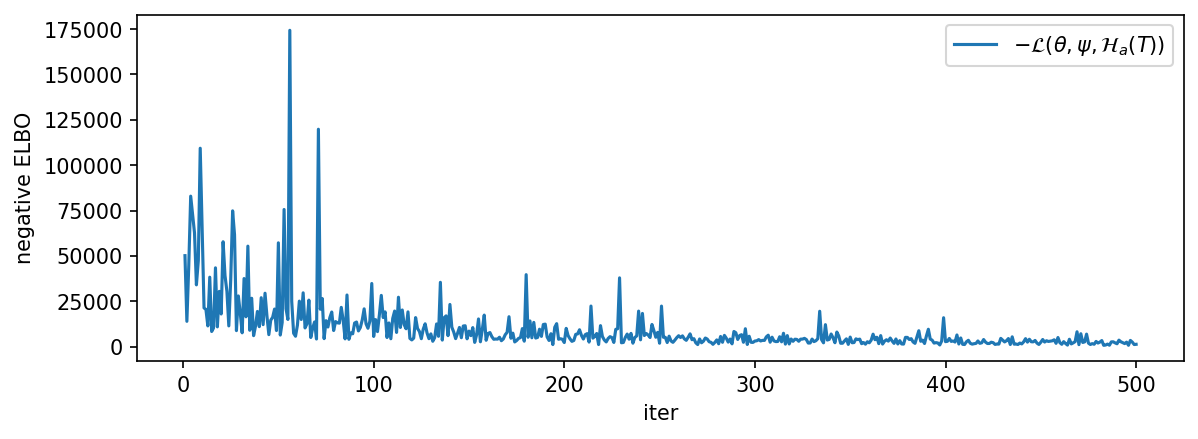

In [152]:
model.plot_loss(losses)